In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()
X = digits.data
y = digits.target
print(X.shape, y.shape)

(1797, 64) (1797,)


In [3]:
y[0:20]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

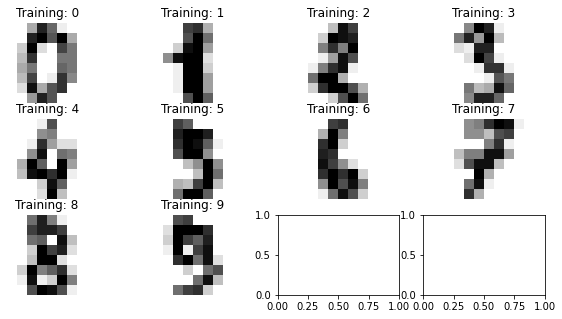

In [4]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
dig = digits.images[0:10]
y_g = y[0:10]
for axl in axes:
    for ax, image, label in zip(axl, dig, y_g):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Training: %i' % label)
    dig = dig[4:]
    y_g = y_g[4:]

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [5]:
from sklearn.cluster import AgglomerativeClustering
clust = AgglomerativeClustering(n_clusters = 10)
clust.fit_predict(digits.data)
ac_predict = clust.labels_

In [6]:
from sklearn.cluster import KMeans
clust = KMeans(n_clusters = 10)
clust.fit_predict(digits.data)
km_predict = clust.labels_

In [7]:
print(ac_predict.shape, km_predict.shape)

(1797,) (1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

**Agglomerative**

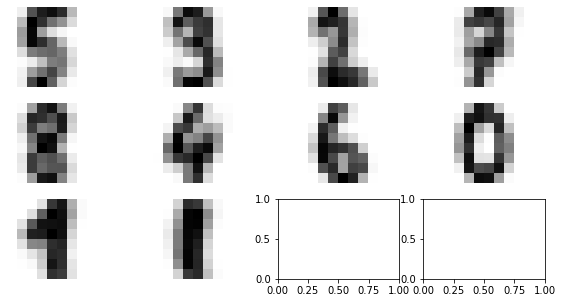

In [8]:
pred_list = []
for i in range(0,10):
    pred_list.append(X[np.where(ac_predict == i)].mean(axis = 0).reshape(8,8))
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
for axl in axes:
    for i, image in zip(axl, pred_list):
        i.set_axis_off()
        i.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    pred_list = pred_list[4:]

**K-Means**

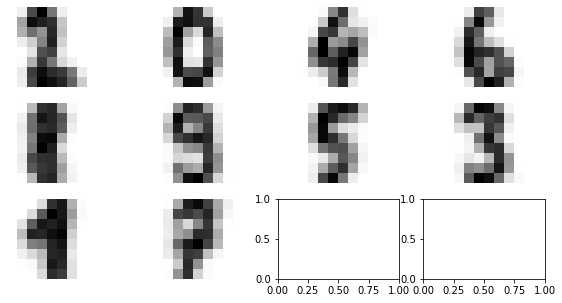

In [9]:
pred_list = []
for i in range(0,10):
    pred_list.append(X[np.where(km_predict == i)].mean(axis = 0).reshape(8,8))
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
for axl in axes:
    for i, image in zip(axl, pred_list):
        i.set_axis_off()
        i.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    pred_list = pred_list[4:]

В целом в обоих случаях силуэты угадываются. Возможно, k-means выглядит чуть лучше

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from tqdm import tqdm

In [11]:
listec_ac = []
listec_km = []
for n in tqdm(range(2,21)):
    clust = AgglomerativeClustering(n_clusters = n)
    clust.fit_predict(digits.data)
    ac_predict = clust.labels_
    listec_ac.append(silhouette_score(digits.data, ac_predict))

    clust_km = KMeans(n_clusters = n)
    clust_km.fit_predict(digits.data)
    km_predict = clust_km.labels_
    listec_km.append(silhouette_score(digits.data, km_predict))

100%|██████████| 19/19 [00:25<00:00,  1.32s/it]


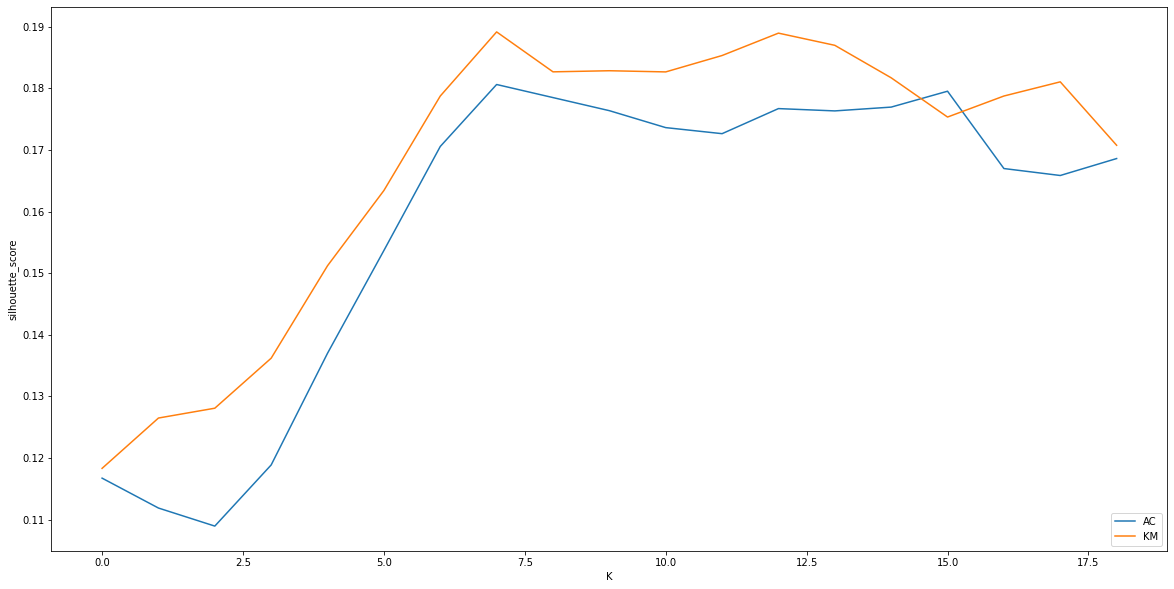

In [12]:
from imp import reload
reload(plt)
plt.figure(figsize=(20,10))
plt.plot(listec_ac, label = 'AC');
plt.plot(listec_km, label = 'KM');
plt.legend(loc = 'lower right');
plt.ylabel('silhouette_score');
plt.xlabel('K');

In [13]:
print('K for max silhouette score (Agglomerative):',listec_ac.index(max(listec_ac)), '-', (max(listec_ac)))
print('K for max silhouette score (KMeans):',listec_km.index(max(listec_km)), '-', (max(listec_km)))

K for max silhouette score (Agglomerative): 7 - 0.18061975703867697
K for max silhouette score (KMeans): 7 - 0.1891543737011892


Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [14]:
u_listec_ac = []
u_listec_km = []
for n in tqdm(range(2,21)):
    clust = AgglomerativeClustering(n_clusters = n)
    clust.fit_predict(digits.data)
    ac_predict = clust.labels_
    u_listec_ac.append(v_measure_score(digits.target, ac_predict))

    clust_km = KMeans(n_clusters = n)
    clust_km.fit_predict(digits.data)
    km_predict = clust_km.labels_
    u_listec_km.append(v_measure_score(digits.target, km_predict))

100%|██████████| 19/19 [00:22<00:00,  1.19s/it]


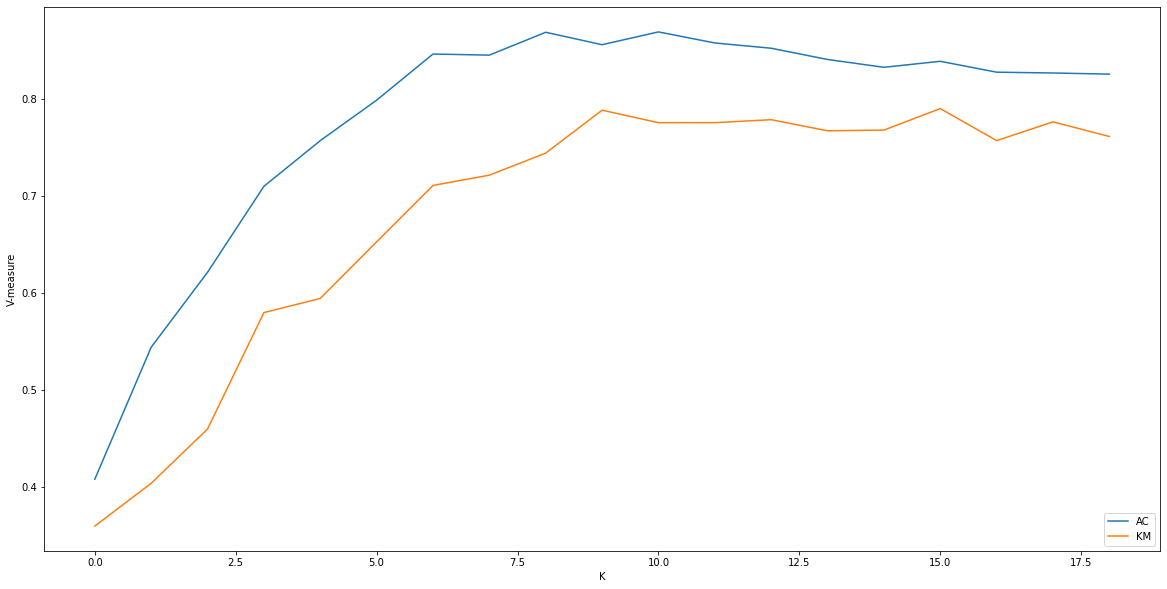

In [15]:
plt.figure(figsize=(20,10))
plt.plot(u_listec_ac, label = 'AC');
plt.plot(u_listec_km, label = 'KM');
plt.legend(loc = 'lower right');
plt.ylabel('V-measure');
plt.xlabel('K');

In [16]:
print('K for max V-measure (Agglomerative):',u_listec_ac.index(max(u_listec_ac)), '-', max(u_listec_ac))
print('K for max V-measure (KMeans):',u_listec_km.index(max(u_listec_km)),'-', max(u_listec_km))

K for max V-measure (Agglomerative): 10 - 0.86854875186737
K for max V-measure (KMeans): 15 - 0.7896521665386752


# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [17]:
from sklearn.decomposition import TruncatedSVD
dec_listec_ac_v = []
dec_listec_ac_sil = []
dec_listec_km_v = []
dec_listec_km_sil = []

for n_c in tqdm([2, 5, 10, 20]):
    svd = TruncatedSVD(n_components = n_c)
    new_X = svd.fit_transform(X)
    
    clust = AgglomerativeClustering(n_clusters = 10)
    clust.fit_predict(new_X)
    ac_predict = clust.labels_
    dec_listec_ac_v.append(v_measure_score(digits.target, ac_predict))
    dec_listec_ac_sil.append(silhouette_score(digits.data, ac_predict))
    
    clust = KMeans(n_clusters = 10)
    clust.fit_predict(new_X)
    km_predict = clust.labels_
    dec_listec_km_v.append(v_measure_score(digits.target, km_predict))
    dec_listec_km_sil.append(silhouette_score(digits.data, km_predict))



100%|██████████| 4/4 [00:03<00:00,  1.12it/s]


In [18]:
print('Max silhouette score (Agglomerative) - original data: {:.4f}'.format( (max(listec_ac))))
print('Max silhouette score (Agglomerative) - SVD: {:.4f}'.format( (max(dec_listec_ac_sil))))
print('')
print('Max silhouette score (KMeans) - original data: {:.4f}'.format((max(listec_km))))
print('Max silhouette score (KMeans) - SVD: {:.4f}'.format((max(dec_listec_km_sil))))
print('')
print('Max V-measure (Agglomerative) - original data: {:.4f}'.format(max(u_listec_ac)))
print('Max V-measure (Agglomerative) - SVD: {:.4f}'.format(max(dec_listec_ac_v)))
print('')
print('Max V-measure (KMeans) - original data: {:.4f}'.format(max(u_listec_km)))
print('Max V-measure (KMeans) - SVD: {:.4f}'.format(max(dec_listec_km_v)))

Max silhouette score (Agglomerative) - original data: 0.1806
Max silhouette score (Agglomerative) - SVD: 0.1766

Max silhouette score (KMeans) - original data: 0.1892
Max silhouette score (KMeans) - SVD: 0.1821

Max V-measure (Agglomerative) - original data: 0.8685
Max V-measure (Agglomerative) - SVD: 0.8260

Max V-measure (KMeans) - original data: 0.7897
Max V-measure (KMeans) - SVD: 0.7383


Ни в одном из случаев не получилось достичь лучшего результата

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [19]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)

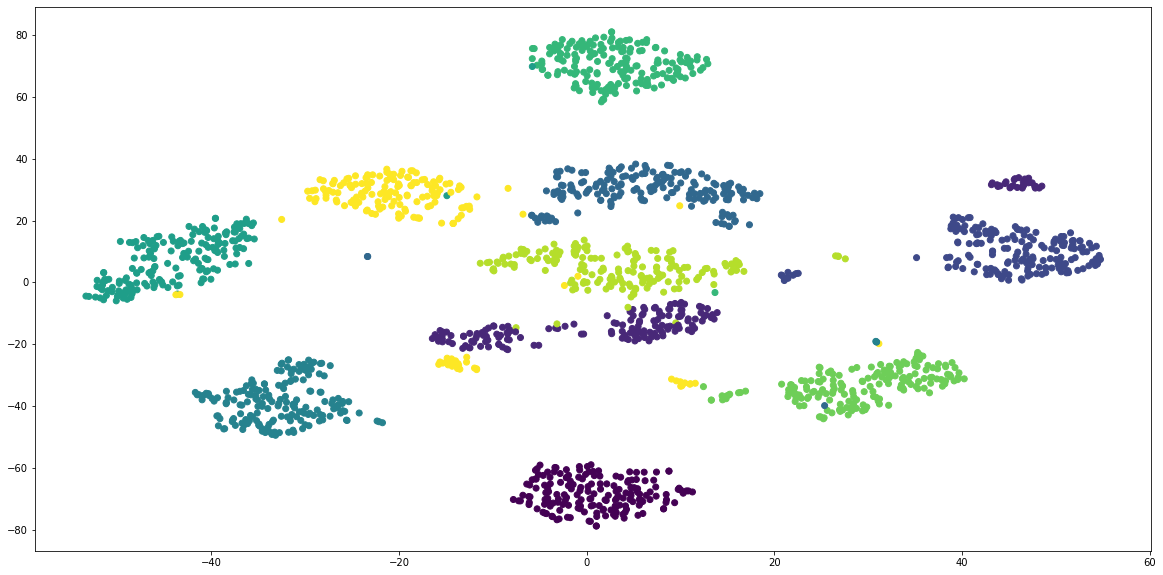

In [20]:
plt.figure(figsize=(20,10));
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], c = y);

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [21]:
clust = AgglomerativeClustering(n_clusters = 10)
clust.fit_predict(X_embedded)
ac_predict = clust.labels_
ac_v_measure_tsne = (v_measure_score(digits.target, ac_predict))
ac_silhouette_tsne = (silhouette_score(digits.data, ac_predict))

In [22]:
clust = KMeans(n_clusters = 10)
clust.fit_predict(X_embedded)
km_predict = clust.labels_
km_v_measure_tsne = (v_measure_score(digits.target, km_predict))
km_silhouette_tsne = (silhouette_score(digits.data, km_predict))

In [23]:
print('Max silhouette score (Agglomerative) - original data: {:.4f}'.format( (max(listec_ac))))
print('Max silhouette score (Agglomerative) - SVD: {:.4f}'.format( (max(dec_listec_ac_sil))))
print('Max silhouette score (Agglomerative) - TSNE: {:.4f}'.format( (ac_silhouette_tsne)))
print('')
print('Max silhouette score (KMeans) - original data: {:.4f}'.format((max(listec_km))))
print('Max silhouette score (KMeans) - SVD: {:.4f}'.format((max(dec_listec_km_sil))))
print('Max silhouette score (KMeans) - TSNE: {:.4f}'.format(km_silhouette_tsne))
print('')
print('Max V-measure (Agglomerative) - original data: {:.4f}'.format(max(u_listec_ac)))
print('Max V-measure (Agglomerative) - SVD: {:.4f}'.format(max(dec_listec_ac_v)))
print('Max V-measure (Agglomerative) - TSNE: {:.4f}'.format(ac_v_measure_tsne))
print('')
print('Max V-measure (KMeans) - original data: {:.4f}'.format(max(u_listec_km)))
print('Max V-measure (KMeans) - SVD: {:.4f}'.format(max(dec_listec_km_v)))
print('Max V-measure (KMeans) - TSNE: {:.4f}'.format(km_v_measure_tsne))

Max silhouette score (Agglomerative) - original data: 0.1806
Max silhouette score (Agglomerative) - SVD: 0.1766
Max silhouette score (Agglomerative) - TSNE: 0.1637

Max silhouette score (KMeans) - original data: 0.1892
Max silhouette score (KMeans) - SVD: 0.1821
Max silhouette score (KMeans) - TSNE: 0.1639

Max V-measure (Agglomerative) - original data: 0.8685
Max V-measure (Agglomerative) - SVD: 0.8260
Max V-measure (Agglomerative) - TSNE: 0.9212

Max V-measure (KMeans) - original data: 0.7897
Max V-measure (KMeans) - SVD: 0.7383
Max V-measure (KMeans) - TSNE: 0.8970


V-мера получилась выше в случае TSNE

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

In [24]:
clust = AgglomerativeClustering(n_clusters = 10)
clust.fit_predict(X_embedded)
ac_predict = clust.labels_

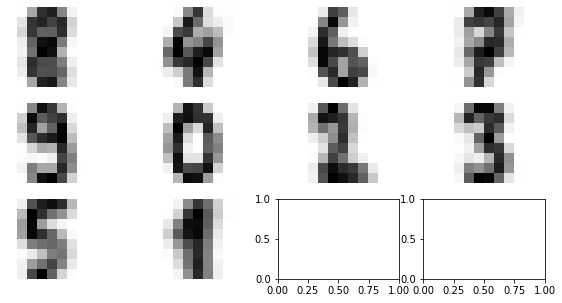

In [25]:
pred_list = []
for i in range(0,10):
    pred_list.append(X[np.where(km_predict == i)].mean(axis = 0).reshape(8,8))
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 5))
for axl in axes:
    for i, image in zip(axl, pred_list):
        i.set_axis_off()
        i.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    pred_list = pred_list[4:]

Каждый кластер соответствует одной цифре

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**Вывод:**  
По итоговым цифрам видно (сравнение качества для всех вариантов выше), что в разных случаях каждый алгоритм мог быть как лучше, так и хуже другого. Итог зависит как от исходных данных, так и от настроек и критериев оценки.  

Снижая размерность признакового пространства возможно улучшить качество оценки алгоритма.